##**Importing Libraries**

In [ ]:
!pip install seaborn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as font_manager
import seaborn as sns
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##**Loading Dataset**

The data description is provided as follows - 


*   Trip Duration (seconds)
*   Start Time and Date
*   Stop Time and Date
*   Start Station Name
*   End Station Name
*   Station ID
*   Station Lat/Long
*   Bike ID
*   User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
*   Gender (Zero=unknown; 1=male; 2=female)
*   Year of Birth



In [ ]:
#downloaded from - https://s3.amazonaws.com/tripdata/index.html
df = pd.read_csv('201701-citibike-tripdata.csv')
df.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542.0,Subscriber,1965.0,2.0
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136.0,Subscriber,1987.0,2.0
2,648,2017-01-01 00:00:57,2017-01-01 00:11:46,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,18147.0,Customer,NaN,0.0
3,631,2017-01-01 00:01:10,2017-01-01 00:11:42,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,21211.0,Customer,NaN,0.0
4,621,2017-01-01 00:01:25,2017-01-01 00:11:47,3143.0,5 Ave & E 78 St,40.776829,-73.963888,3152.0,3 Ave & E 71 St,40.768737,-73.961199,26819.0,Customer,NaN,0.0


In [ ]:
df.dtypes

Trip Duration                int64
Start Time                  object
Stop Time                   object
Start Station ID           float64
Start Station Name          object
Start Station Latitude     float64
Start Station Longitude    float64
End Station ID             float64
End Station Name            object
End Station Latitude       float64
End Station Longitude      float64
Bike ID                    float64
User Type                   object
Birth Year                 float64
Gender                     float64
dtype: object

##**Data Visualization & EDA**

In [ ]:
df.shape

(454787, 15)

Checking the variables in the dataset that have missing values and also the number of missing values

In [ ]:
df.isnull().sum()

Trip Duration                  0
Start Time                     0
Stop Time                      1
Start Station ID               1
Start Station Name             1
Start Station Latitude         1
Start Station Longitude        1
End Station ID                 1
End Station Name               1
End Station Latitude           1
End Station Longitude          1
Bike ID                        1
User Type                   2054
Birth Year                 18185
Gender                         1
dtype: int64

Therefore, User Type and Birth Year are the only ones with missing values

####**EDA for User Type missing values**

In [ ]:
#Counting the number of categories for User Types
df["User Type"].value_counts()

Subscriber    438348
Customer       14385
Name: User Type, dtype: int64

In [ ]:
#There may be a typo in printing 'Subscribe'. It probably is 'Subscriber'
#There is ONE value in the column 'Subscribe'. This one value can be renamed
df["User Type"] = df["User Type"].replace({'Subscribe':'Subscriber'})
df["User Type"].value_counts()

Subscriber    438348
Customer       14385
Name: User Type, dtype: int64

In [ ]:
df["User Type"].isnull().sum()

2054

In [ ]:
#missing value % in User Type
((df["User Type"].isnull().sum()) / (len(df["User Type"])))*100

0.4516399985047946

The Missing values in User type constitue of about 0.44% of the entire column values. **There is no harm in dropping rows with null User Type values**

In [ ]:
df.dropna(subset=['User Type'], inplace = True)
df.shape

(452733, 15)

####**EDA for Birth Year**

In [ ]:
(df["Birth Year"].isnull().sum() / len(df["Birth Year"]))*100

4.016274492913041

Nearly 4% of the total Birth Year values in the dataset are Null. We can decide to either remove these rows or replace the missing values with something else.

In [ ]:
print('Unique Birth Years in the Dataset: \n',(df['Birth Year'].unique()),'\n')

Unique Birth Years in the Dataset: 
 [1965. 1987.   nan 2000. 1973. 1977. 1989. 1980. 1993. 1992. 1996. 1964.
 1970. 1994. 1969. 1984. 1974. 1991. 1968. 1986. 1943. 1990. 1985. 1995.
 1963. 1979. 1983. 1975. 1988. 1981. 1997. 1954. 1966. 1978. 1982. 1976.
 1953. 1942. 1959. 1971. 1946. 1948. 1962. 1999. 1967. 1960. 1961. 1951.
 1949. 1886. 1957. 1956. 1972. 1955. 1998. 1952. 1958. 1945. 1950. 1941.
 1940. 1934. 1947. 1944. 1938. 1926. 1885. 1936. 1932. 1939. 1923. 1900.
 1899. 1935. 1912. 1937. 1901. 1921. 1893. 1917. 1910. 1918. 1931. 1895.] 



Besides **NaN**, the dataset contains some unrealistic age values, including some even from the **19th Century**! These can safely be removed.

A Box plot can visualize the outliers/unrealistic values better - 

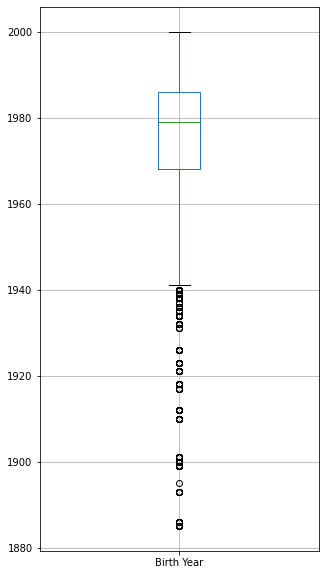

In [ ]:
boxplot = df.boxplot(column =['Birth Year'], figsize=(5,10))

In [ ]:
#Identifying People born before 1940 (80 Years and Older)
#We would like to keep only people ages 80 and below
df = df[(df['Birth Year'] >= 1940.0)]
df.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542.0,Subscriber,1965.0,2.0
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136.0,Subscriber,1987.0,2.0
5,666,2017-01-01 00:01:51,2017-01-01 00:12:57,3163.0,Central Park West & W 68 St,40.773407,-73.977825,3163.0,Central Park West & W 68 St,40.773407,-73.977825,16050.0,Subscriber,2000.0,1.0
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499.0,Broadway & W 60 St,40.769155,-73.981918,479.0,9 Ave & W 45 St,40.760193,-73.991255,27294.0,Subscriber,1973.0,1.0
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362.0,Broadway & W 37 St,40.751726,-73.987535,445.0,E 10 St & Avenue A,40.727408,-73.981420,23288.0,Subscriber,1977.0,2.0


In [ ]:
#Having removed 80 or older people from the dataset, we can re-check the null values
df['Birth Year'].isnull().sum()

0

The above Dataframe has only people with ***ages 90 and below***

We can safely conclude that all the unrealistic birth years in our dataset were removed by placing a condition of taking data of only those who are 90 or younger (because we would like to believe that it is unlikely for senior citizens aged 90 or above to cycle in a busy city like NYC!)

##**Q1) Top 5 Stations with the most starts**

*showing # of starts*

####**EDA for Trip Durations per Stations**

There are some trips with total duration of less than **90 seconds (1.5 minutes)**. In ideal world, we must not factor such trips as it is very likely that the bikes may have been broken and as soon as the use found out, they docked it and picked up another bike within a minute or two.

**We shall check this Hypothesis and if there are considerable number of such trips, we can consider not including those**

In [ ]:
#Testing Hypothesis
df_bikenum = pd.DataFrame()
df_bikenum['First Bike'] = df[df['Trip Duration'] < 90]['Start Station Name']
df_bikenum['Second Bike'] = df[df['Trip Duration'] < 90]['End Station Name']
df_bikenum.shape

(1998, 2)

In [ ]:
df_bikenum.head(20)

,First Bike,Second Bike
59,5 Ave & E 73 St,5 Ave & E 73 St
296,St Marks Pl & 2 Ave,St Marks Pl & 1 Ave
338,Canal St & Rutgers St,Pike St & E Broadway
857,Monroe St & Bedford Ave,Monroe St & Bedford Ave
1049,Berry St & N 8 St,N 11 St & Wythe Ave
1178,Carroll St & 5 Ave,5 Ave & 3 St
1207,Mercer St & Bleecker St,Mercer St & Bleecker St
1210,Howard St & Centre St,Howard St & Centre St
1219,W 17 St & 8 Ave,9 Ave & W 18 St
1264,Pike St & E Broadway,Division St & Bowery


In [ ]:
#Checking the same hypothesis with Geo Coordinates
df_geocoord = pd.DataFrame()
df_geocoord['First Bike'] = df[df['Trip Duration'] < 90]['Start Station Longitude']
df_geocoord['Second Bike'] = df[df['Trip Duration'] < 90]['End Station Longitude']
df_geocoord.shape

(1998, 2)

In [ ]:
df_geocoord.head(10)

,First Bike,Second Bike
59,-73.966853,-73.966853
296,-73.987140,-73.985649
338,-73.989900,-73.992939
857,-73.953809,-73.953809
1049,-73.958525,-73.957824
1178,-73.981483,-73.983524
1207,-73.996621,-73.996621
1210,-73.999733,-73.999733
1219,-74.001497,-74.003664
1264,-73.992939,-73.997047


*There are 3000+ such cases and they cannot be ignored. **Moreover, as we suspected, many of these trips have the same start and end stations**. We can thus remove those specific trips that have the same station start & end names*

In [ ]:
#Cleaning Dataset of these trips
del(df_bikenum)
df = df.drop(df.index[(df['Trip Duration'] < 90) &
                      (df['Start Station Latitude'] == df['End Station Latitude'])])

####**Top 5 Stations**

In [ ]:
#Top 5 Stations with most starts
df1 = pd.DataFrame()
df1['Top 5 Stations'] = df["Start Station Name"].value_counts().head().index
df1['Number of Starts'] = df["Start Station Name"].value_counts().head().values
#df1['Top 5 Stations'] = df1["Top 5 Stations"].cat.remove_unused_categories()
#df1['Top 5 Stations'] = df["Top 5 Stations"].astype('object')
df1

,Top 5 Stations,Number of Starts
0,Pershing Square North,5469
1,W 21 St & 6 Ave,3279
2,Broadway & E 22 St,3058
3,E 17 St & Broadway,3040
4,8 Ave & W 33 St,3036


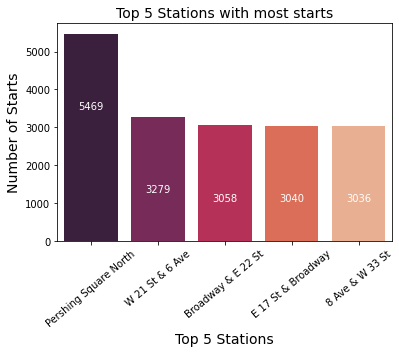

In [ ]:
#Alternate plotting method

ax = sns.barplot('Top 5 Stations', 'Number of Starts', data = df1,
                 palette = "rocket")
ax.set_title('Top 5 Stations with most starts', fontsize = 14)
#rcParams['figure.figsize'] = 12,7
ax.set_xticklabels(ax.get_xticklabels(), rotation = 40)
ax.set_xlabel('Top 5 Stations', fontsize=14)
ax.set_ylabel('Number of Starts', fontsize=14)
for index, row in df1.iterrows():
  ax.text(index, row['Number of Starts']-2000, row['Number of Starts'],
          color = 'white', ha='center', fontsize = 10)
plt.show()

##**Q2) Trip Duration by User Type**

####**EDA for Large Trip Durations**

We notice that the maximum value for trip duration is abnormally large. Infact, there are several values which are much larger than the mean trip duration in the dataset. This shouldn't be the case as we will not be able to deduce anything from this kind of distribution plot.

In [ ]:
#Addressing the large number of Trip Durations
df['Trip Duration'].max()

5325688

In [ ]:
#Row which has this abnormally large distance value
df.loc[df['Trip Duration']==df['Trip Duration'].max()]

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
207738,5325688,2017-01-11 21:52:17,2017-03-14 14:13:45,302.0,Avenue D & E 3 St,40.720828,-73.977932,3250.0,NYCBS Depot - PIT,40.71691,-73.983838,18223.0,Subscriber,1990.0,1.0


In [ ]:
df.nlargest(5, ['Trip Duration'])

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
207738,5325688,2017-01-11 21:52:17,2017-03-14 14:13:45,302.0,Avenue D & E 3 St,40.720828,-73.977932,3250.0,NYCBS Depot - PIT,40.716910,-73.983838,18223.0,Subscriber,1990.0,1.0
406054,3152489,2017-01-19 15:15:38,2017-02-25 02:57:07,325.0,E 19 St & 3 Ave,40.736245,-73.984738,291.0,Madison St & Montgomery St,40.713126,-73.984844,24795.0,Subscriber,1964.0,2.0
70824,1305987,2017-01-04 20:20:02,2017-01-19 23:06:30,3435.0,Grand St & Elizabeth St,40.718822,-73.995960,504.0,1 Ave & E 16 St,40.732219,-73.981656,20054.0,Subscriber,1983.0,1.0
275555,784198,2017-01-13 18:11:42,2017-01-22 20:01:40,455.0,1 Ave & E 44 St,40.750020,-73.969053,3237.0,21 St & 41 Ave,40.753833,-73.942677,16849.0,Subscriber,1975.0,1.0
184835,622702,2017-01-11 09:38:44,2017-01-18 14:37:07,3219.0,NYCBS Depot - STY,40.729193,-73.976655,3219.0,NYCBS Depot - STY,40.729193,-73.976655,23368.0,Subscriber,1988.0,2.0


Realistically speaking, even if a rider decides to rent the bike overnight, the total trip duration shouldn't exceed 48 hours at the most. This is conservative as the mean trip duration lies somewhere around 2 hours. Therefore, we can decide to remove all those trip durations that exceed around 24-27 hrs. Also, we can try to play around with this threshold and see what percentage of trip durations in the dataset belong to those that exceed different time limits

We first find out what effect would dropping those rows have on the dataset.

In [ ]:
#Rows that exceed our set threshold of trip duration
df_trip_dur = df.loc[df['Trip Duration']>=9999]
df_trip_dur.shape

(334, 15)

In [ ]:
#Percentage of trip durations that exceed 24 hours in the dataset
(df_trip_dur.shape[0] / df["Trip Duration"].shape[0])*100

0.07704657857828301

Rows that have trip duration of more than **9999 seconds (2.7 hrs)** constitute about **0.08%** of the entire dataset. There is no harm in dropping these rows if by doing so, we can visualize our data well without compromising the effectivity of our predictive model.

In [ ]:
#Dropping the stated rows
df = df.loc[df['Trip Duration']<=9999]
df.shape

(433170, 15)

In [ ]:
df['Trip Duration'].describe()

count    433170.000000
mean        654.729817
std         492.806886
min          61.000000
25%         327.000000
50%         515.000000
75%         827.000000
max        9989.000000
Name: Trip Duration, dtype: float64

In [ ]:
#Performing a Sanity check again
df.nlargest(5, ['Trip Duration'])

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
318634,9989,2017-01-16 11:21:21,2017-01-16 14:07:50,3295.0,Central Park W & W 96 St,40.791270,-73.964839,500.0,Broadway & W 51 St,40.762288,-73.983362,19426.0,Subscriber,1946.0,1.0
220929,9939,2017-01-12 11:17:03,2017-01-12 14:02:42,3224.0,W 13 St & Hudson St,40.739974,-74.005139,3428.0,8 Ave & W 16 St,40.740983,-74.001702,25828.0,Subscriber,1988.0,1.0
368650,9908,2017-01-18 13:47:24,2017-01-18 16:32:33,253.0,W 13 St & 5 Ave,40.735439,-73.994539,445.0,E 10 St & Avenue A,40.727408,-73.981420,17972.0,Subscriber,1985.0,1.0
441477,9733,2017-01-20 15:15:50,2017-01-20 17:58:03,3142.0,1 Ave & E 62 St,40.761227,-73.960940,3323.0,W 106 St & Central Park West,40.798186,-73.960591,25623.0,Subscriber,1999.0,2.0
48580,9718,2017-01-04 09:33:17,2017-01-04 12:15:15,438.0,St Marks Pl & 1 Ave,40.727791,-73.985649,493.0,W 45 St & 6 Ave,40.756800,-73.982912,26699.0,Subscriber,1983.0,1.0


In [ ]:
df['User Type'].dtypes

dtype('O')

####**Average Trip Duration By the 2 User Types (in Seconds)**

In [ ]:
#Calculating Trip Duration
df_TD = pd.DataFrame()
df_TD['Avg. Trip Duration'] = round(df.groupby('User Type')['Trip Duration'].mean(),2)
df_TD = df_TD.reset_index()
df_TD['User Type'] = df_TD['User Type'].astype('object')

    User Type  Trip Duration
0    Customer    1932.174825
1  Subscriber     654.307962




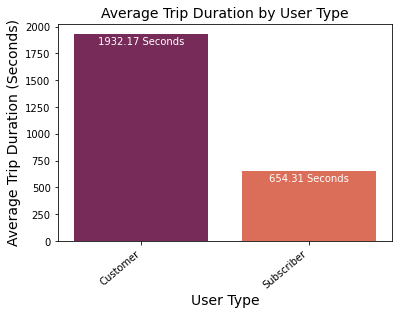

In [ ]:
#Grouping User Types with the average duration for their respective trips
grouped_user = df[["User Type","Trip Duration"]]
grouped_user = grouped_user.groupby(['User Type'], as_index=False).mean()
print(grouped_user)
print('\n')
ax2 = sns.barplot('User Type', 'Avg. Trip Duration', data = df_TD,
                  palette = 'rocket')
ax2.set_title('Average Trip Duration by User Type', fontsize=14)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 40, ha = 'right')
ax2.set_xlabel('User Type', fontsize=14)
ax2.set_ylabel('Average Trip Duration (Seconds)', fontsize=14)
for index,row in df_TD.iterrows():
  ax2.text(index,row['Avg. Trip Duration']-100,
           (str(row['Avg. Trip Duration'])+" Seconds"),
           color = 'white', ha = "center", fontsize = 10)
plt.show()

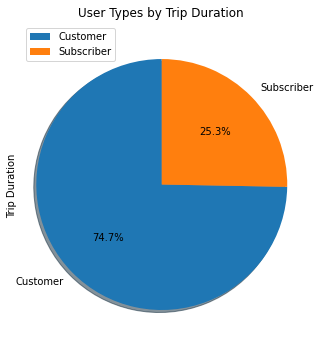

In [ ]:
grouped_df_pie = grouped_user.groupby('User Type', axis = 0).sum()

grouped_df_pie.plot(kind='pie',subplots = True, figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            startangle=90,     # start angle 90°
                            shadow=True,       # add shadow     
                            )

plt.title('User Types by Trip Duration')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

We can say that the longest no. of trips are performed by 'Customer' User Types. 

##**Q3) Most Popular Trips**

*Based on Start Station and End Station*

We look at the combinations of Start Station & End Stations that occur most frequenty and perform feature engineering.

In [ ]:
#Identifying the popular trip routes from groupby function
df_trips = pd.DataFrame()
df_trips = df.groupby(["Start Station Name","End Station Name"]).size().reset_index(name = "Number of Trips")
df_trips = df_trips.sort_values("Number of Trips", ascending = False)
df_trips["Start Station Name"] = df_trips["Start Station Name"].astype(str)
df_trips["End Station Name"] = df_trips["End Station Name"].astype(str)
df_trips["Trip Route"] = df_trips["Start Station Name"] + " -- TO -- " + df_trips["End Station Name"]
df_trips = df_trips[:10]
df_trips = df_trips.drop(["Start Station Name","End Station Name"], axis = 1)
df_trips.head(10)

,Number of Trips,Trip Route
37943,263,E 7 St & Avenue A -- TO -- Cooper Square & E 7 St
45630,227,Greenwich Ave & Charles St -- TO -- Greenwich ...
67860,209,W 21 St & 6 Ave -- TO -- 9 Ave & W 22 St
57319,204,Pershing Square North -- TO -- Broadway & W 32 St
57381,193,Pershing Square North -- TO -- E 24 St & Park ...
31383,192,E 33 St & 2 Ave -- TO -- W 33 St & 7 Ave
55478,184,N 6 St & Bedford Ave -- TO -- Wythe Ave & Metr...
59243,173,Richardson St & N Henry St -- TO -- Graham Ave...
57554,172,Pershing Square North -- TO -- W 33 St & 7 Ave
80424,169,Wythe Ave & Metropolitan Ave -- TO -- N 6 St &...


####**Visualizing by Bar Plots**

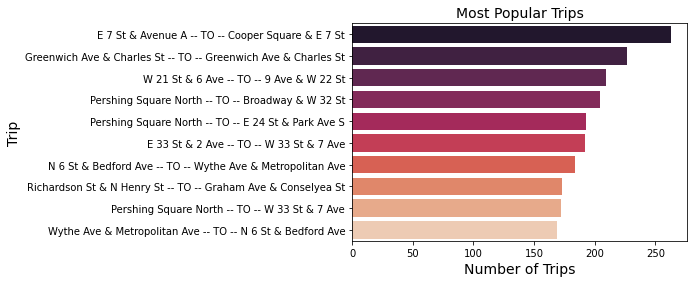

In [ ]:
#5 Most popular routes along with their frequency stored in dataframe
ax4 = sns.barplot(x='Number of Trips',y='Trip Route', data = df_trips, palette = 'rocket')
ax4.set_title('Most Popular Trips', fontsize = 14)
ax4.set_ylabel('Trip', fontsize = 14)
ax4.set_xlabel('Number of Trips',fontsize = 14)
#for index, row in df_trips.iterrows():
    #ax4.text(row['Number of Trips']-200, index,
            # (str(row['Number of Trips'])+" Trips"), 
            # color = 'white', ha  = "center", fontsize = 10)
plt.show()

####**Alternate method by feature engineering**

In [ ]:
#Engineering Features 'Counts' and 'Max' for this
#We first group the start and end stations together and transform the dataset
df['Count']=df.groupby(['Start Station Name','End Station Name'])['End Station Name'].transform('size')

#We than calculate the no. of times that unique combination of start and end stations occurs in the dataset
#df['Max']=df.groupby(['Start Station Name'])['Count'].transform('max')==df['Count']
df3 = df[['Start Station Name','End Station Name','Count']]

#Highest Occuring Count
highest_count = df3.Count.max()

In [ ]:
#Required Combination
df3.loc[df3['Count'] == highest_count].head(1)

,Start Station Name,End Station Name,Count
3771,E 7 St & Avenue A,Cooper Square & E 7 St,263


So we know that the most popular trips were between Stations ***E 7 St & Avenue A*** and ***Cooper Square & E 7 St***	

In order to visualize the most popular trip routes, we first list out the **5 most frequently used routes** and give them **Route IDs**

In [ ]:
df_pop = df[['Start Station Name','End Station Name','Count']]
df_pop = df_pop.groupby(['Count'], as_index = False).sum()
#dist_perf_pivot = df_dist_perf.pivot(index = 'Age', columns = 'Gender')
df_pop.tail(5)

,Count,Start Station Name,End Station Name
140,193,Pershing Square NorthPershing Square NorthPers...,E 24 St & Park Ave SE 24 St & Park Ave SE 24 S...
141,204,Pershing Square NorthPershing Square NorthPers...,Broadway & W 32 StBroadway & W 32 StBroadway &...
142,209,W 21 St & 6 AveW 21 St & 6 AveW 21 St & 6 AveW...,9 Ave & W 22 St9 Ave & W 22 St9 Ave & W 22 St9...
143,227,Greenwich Ave & Charles StGreenwich Ave & Char...,Greenwich Ave & Charles StGreenwich Ave & Char...
144,263,E 7 St & Avenue AE 7 St & Avenue AE 7 St & Ave...,Cooper Square & E 7 StCooper Square & E 7 StCo...


Better Visualization requires our bar plots to have x-labels as the specific routes which are identified as the most popular ones. We will give names to Start & End station routes by adding new columns

In [ ]:
#A new column with start station code (limited characters identifying the station name)
df_pop['Start Code'] = df_pop['Start Station Name'].apply(lambda x : x[0:10])

#A new column with end station code (limited characters identifying the station name)
df_pop['End Code'] = df_pop['End Station Name'].apply(lambda x : x[0:10])

#A new column that shows the route with codes for the bar plots
df_pop['Route ID'] = df_pop['Start Code'] + ' - ' + df_pop['End Code']
df_pop.tail(5)

,Count,Start Station Name,End Station Name,Start Code,End Code,Route ID
140,193,Pershing Square NorthPershing Square NorthPers...,E 24 St & Park Ave SE 24 St & Park Ave SE 24 S...,Pershing S,E 24 St &,Pershing S - E 24 St &
141,204,Pershing Square NorthPershing Square NorthPers...,Broadway & W 32 StBroadway & W 32 StBroadway &...,Pershing S,Broadway &,Pershing S - Broadway &
142,209,W 21 St & 6 AveW 21 St & 6 AveW 21 St & 6 AveW...,9 Ave & W 22 St9 Ave & W 22 St9 Ave & W 22 St9...,W 21 St &,9 Ave & W,W 21 St & - 9 Ave & W
143,227,Greenwich Ave & Charles StGreenwich Ave & Char...,Greenwich Ave & Charles StGreenwich Ave & Char...,Greenwich,Greenwich,Greenwich - Greenwich
144,263,E 7 St & Avenue AE 7 St & Avenue AE 7 St & Ave...,Cooper Square & E 7 StCooper Square & E 7 StCo...,E 7 St & A,Cooper Squ,E 7 St & A - Cooper Squ


In [ ]:
#5 Most popular routes along with their frequency stored in dataframe
popular_trips_names = df_pop.tail(5)
popular_trips_names

,Count,Start Station Name,End Station Name,Start Code,End Code,Route ID
140,193,Pershing Square NorthPershing Square NorthPers...,E 24 St & Park Ave SE 24 St & Park Ave SE 24 S...,Pershing S,E 24 St &,Pershing S - E 24 St &
141,204,Pershing Square NorthPershing Square NorthPers...,Broadway & W 32 StBroadway & W 32 StBroadway &...,Pershing S,Broadway &,Pershing S - Broadway &
142,209,W 21 St & 6 AveW 21 St & 6 AveW 21 St & 6 AveW...,9 Ave & W 22 St9 Ave & W 22 St9 Ave & W 22 St9...,W 21 St &,9 Ave & W,W 21 St & - 9 Ave & W
143,227,Greenwich Ave & Charles StGreenwich Ave & Char...,Greenwich Ave & Charles StGreenwich Ave & Char...,Greenwich,Greenwich,Greenwich - Greenwich
144,263,E 7 St & Avenue AE 7 St & Avenue AE 7 St & Ave...,Cooper Square & E 7 StCooper Square & E 7 StCo...,E 7 St & A,Cooper Squ,E 7 St & A - Cooper Squ


In [ ]:
# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'sans-serif', 'size':'18', 'color':'black', 'weight':'normal',
  'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'sans-serif', 'size':'14'}

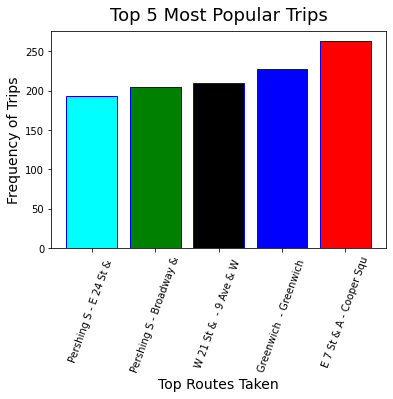

In [ ]:
#Visualizing with Bar Plot
plt.bar(popular_trips_names['Route ID'], popular_trips_names['Count'],
        color=['cyan', 'green', 'black', 'blue', 'red'],
        edgecolor='blue')
plt.title('Top 5 Most Popular Trips', **title_font)
plt.xlabel('Top Routes Taken', **axis_font)
plt.xticks(rotation=70)
plt.ylabel('Frequency of Trips', **axis_font)
plt.show()

##**Q4) Rider Performance by Gender and Age based on Avg Trip Distance**

*Station to Station - Median Speed (Distance Travelled / Trip Duration)*

In [ ]:
df.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Count
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542.0,Subscriber,1965.0,2.0,3
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136.0,Subscriber,1987.0,2.0,2
5,666,2017-01-01 00:01:51,2017-01-01 00:12:57,3163.0,Central Park West & W 68 St,40.773407,-73.977825,3163.0,Central Park West & W 68 St,40.773407,-73.977825,16050.0,Subscriber,2000.0,1.0,7
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499.0,Broadway & W 60 St,40.769155,-73.981918,479.0,9 Ave & W 45 St,40.760193,-73.991255,27294.0,Subscriber,1973.0,1.0,26
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362.0,Broadway & W 37 St,40.751726,-73.987535,445.0,E 10 St & Avenue A,40.727408,-73.981420,23288.0,Subscriber,1977.0,2.0,2


####**Calculating Distance Travelled**

*Using Coordinates Provided*

In [ ]:
#Adding Distance Travelled using Latitude and Longitudes
radius = 6373 #Earth's Radius in units km
def DistanceTravelled(df):
  lat1 = df['Start Station Latitude']
  long1 = df['Start Station Longitude']
  lat2 = df['End Station Latitude']
  long2 = df['End Station Longitude']

  dlat = math.radians(lat2-lat1)
  dlong = math.radians(long2-long1)
  a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlong/2) * math.sin(dlong/2)
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  d = (radius * c)*1000

  return d

In [ ]:
df['Distance Travelled (Meters)'] = df.apply(DistanceTravelled, axis = 1)
df['Median Speed (m/s)'] = (df['Distance Travelled (Meters)']/df['Trip Duration'])
df.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Count,Distance Travelled (Meters),Median Speed (m/s)
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542.0,Subscriber,1965.0,2.0,3,874.394902,1.285875
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136.0,Subscriber,1987.0,2.0,2,2160.858819,1.685537
5,666,2017-01-01 00:01:51,2017-01-01 00:12:57,3163.0,Central Park West & W 68 St,40.773407,-73.977825,3163.0,Central Park West & W 68 St,40.773407,-73.977825,16050.0,Subscriber,2000.0,1.0,7,0.000000,0.000000
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499.0,Broadway & W 60 St,40.769155,-73.981918,479.0,9 Ave & W 45 St,40.760193,-73.991255,27294.0,Subscriber,1973.0,1.0,26,1269.844833,2.271637
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362.0,Broadway & W 37 St,40.751726,-73.987535,445.0,E 10 St & Avenue A,40.727408,-73.981420,23288.0,Subscriber,1977.0,2.0,2,2753.588103,3.333642


In [ ]:
df['Distance Travelled (Meters)'].value_counts()

0.000000       4508
683.983352      376
400.234484      353
1401.259034     331
1429.416162     326
               ... 
2233.945739       1
3547.458040       1
2469.618435       1
6489.115184       1
2462.665626       1
Name: Distance Travelled (Meters), Length: 52029, dtype: int64

####**EDA on Circular Trips Travelled**

We notice that of the different distances travelled, we have a vast majority of those as **zero meters**, meaning the Start & the End Station for those journeys were the same. These **'circular trips'** are very much possible in real life scenario! These could include cases where bikes were hired for a prolonged journey and returned at the same spot. But previusly, our function defaults those trips to have travelled 0 distance if only the trip duration too was minimal. 

But in these cases, distance and speed both will have 0 values and the trip duration will certainly be more than 90 seconds. This will be an issue when during feature pre-processing, we subject these columns through log transformation or scaling.

In [ ]:
#Lets take a look at the Time Durations of trips that have 0 distance travelled
df.loc[df['Distance Travelled (Meters)'] == 0.00, 'Trip Duration']
start_end_same = df.loc[df['Distance Travelled (Meters)'] == 0.00,
                        'Trip Duration'].iloc[0:]
start_end_same = pd.DataFrame(data = start_end_same, index = None)
start_end_same.head()

,Trip Duration
5,666
22,570
134,1331
283,264
289,150


In [ ]:
start_end_same.shape[0]

4508

In [ ]:
start_end_same.describe()

,Trip Duration
count,4508.000000
mean,1127.587622
std,968.943583
min,90.000000
25%,451.000000
50%,905.500000
75%,1548.000000
max,9264.000000


It is important to decide what should be done with these values as they are significant enough to make a difference to our target variable 'Time Duration'. Can we cannot ignore them given that their distribution is not uniform (mean & 50% are not similar)? Since out goal is to be able to predict how much time it will take for a rider to get to different places, realistically speaking, we'd like to help those who want to plan their journey between **two distinct points**

Besides, this data is irrelevant for predictive modelling in this case. Someone on a circular trip can obviously be assumed to know the trip duration and doesn't need our model to tell them that. Hence, we can safely decide to **drop these values.**

####**EDA for '0.00' Coordinates**

We have some Start Coordinates as (0.00,0.00). These are trips which were taken away for repair or for other purposes. These should be dropped.

In [ ]:
print(df.loc[df['Start Station Latitude'] == 0.00, 'Distance Travelled (Meters)'])
print(df.loc[df['Start Station Longitude'] == 0.00, 'Distance Travelled (Meters)'])

Series([], Name: Distance Travelled (Meters), dtype: float64)
Series([], Name: Distance Travelled (Meters), dtype: float64)


In [ ]:
print(df.loc[df['End Station Latitude'] == 0.00, 'Distance Travelled (Meters)'])
print(df.loc[df['End Station Longitude'] == 0.00, 'Distance Travelled (Meters)'])

Series([], Name: Distance Travelled (Meters), dtype: float64)
Series([], Name: Distance Travelled (Meters), dtype: float64)


In [ ]:
#Dropping rows where distance & speed = 0
df = df[df['Distance Travelled (Meters)'] !=0]
df.shape

(428662, 18)

####**Rider Performance**

*Based on Gender, Age, Distance and Speed*

In [ ]:
#Adding a new column 'Age'
df['Age'] = (2020 - df['Birth Year'])

In [ ]:
df.Age.sort_values(ascending=False)

299171    80.0
180750    80.0
186433    80.0
349816    80.0
338531    80.0
          ... 
319846    20.0
174561    20.0
159749    20.0
174601    20.0
178723    20.0
Name: Age, Length: 428662, dtype: float64

#####**EDA for Rider Age**

In [ ]:
#Checking number of trips made by really old people
df['Age'][(df['Age'] >= 75)&(df['Age'] <= 80)].count()

1674

It is normal for a few senior citizens to cycle, however, the existing dataset has around **2700+ cycle trips from people aged between 75 & 80** alone!

Although this is very subjective, but we'd like to eliminate as much false data as possible by putting a generous cap at 65 years of age and under.

In [ ]:
df['Age'].nunique()

61

In [ ]:
#Checking the trip durations made by these old people
df_age = pd.DataFrame()
df_age = df.groupby(["Age"]).size().reset_index(name="Number of Trips")
df_age = df_age.sort_values("Number of Trips", ascending = False)
df_age.head()

,Age,Number of Trips
15,35.0,16704
14,34.0,16185
12,32.0,16133
11,31.0,15732
16,36.0,15611


In [ ]:
#Trips made by poeple between ages 70 and 80
#df_age[(df_age['Age'] >= 70)&(df_age['Age'] <= 80)]
df_age[(df_age['Age'] >= 65)]

,Age,Number of Trips
45,65.0,3249
47,67.0,3220
46,66.0,3006
48,68.0,1914
49,69.0,1744
50,70.0,1231
51,71.0,1122
52,72.0,962
53,73.0,832
54,74.0,746


In [ ]:
#Removing Trips made by people over 65 years of age
df = df.drop(df.index[(df['Age']>65)])

#####**Visualization by Pivot Tables**

In [ ]:
#Making sure that we have atleast 3 kinds of genders mentioned
df.Gender.unique()

array([2., 1., 0.])

Some of the rows in 'Unknown' gender contain missing values that spoils the visual. We can impute these values, but given their proportion, the information gain would be negligible. *So it is better to remove the Unknown Gender for the purpose of this part and only visualize data for Male and Female.*

In [ ]:
#Grouping Data as per gender and age with distance & speed
df_dist_perf = df[['Gender', 'Age', 'Distance Travelled (Meters)']]
df_dist_perf = df_dist_perf.drop(df_dist_perf.index[(df_dist_perf['Gender'] == 0)])

df_speed_perf = df[['Gender', 'Age', 'Median Speed (m/s)']]
df_speed_perf = df_speed_perf.drop(df_speed_perf.index[(df_speed_perf['Gender'] == 0)])

df_dist_perf = df_dist_perf.groupby(['Gender','Age'], as_index = False).mean().fillna(0)
df_speed_perf = df_speed_perf.groupby(['Gender','Age'], as_index = False).mean().fillna(0)

In [ ]:
#Performance by Distance Travelled (Pivot Table)
dist_perf_pivot = df_dist_perf.pivot(index = 'Age', columns = 'Gender').fillna(0)
dist_perf_pivot.head(10)

Distance Travelled (Meters)             
Gender                         1.0          2.0
Age                                            
20.0                   1683.661357   981.939629
21.0                   1340.775206  1647.733537
22.0                   1457.559662  1842.644881
23.0                   1519.197073  1438.169050
24.0                   1517.081721  1530.559305
25.0                   1488.787006  1606.054543
26.0                   1619.744800  1459.604881
27.0                   1717.076338  1821.481528
28.0                   1655.279425  1785.938661
29.0                   1632.416266  1733.064174

The table above shows the ***average distance*** covered by *different ages of riders* and their respective *genders*

In [ ]:
#Performance by Speed (Pivot Table)
speed_perf_pivot = df_speed_perf.pivot(index = 'Age', columns = 'Gender').fillna(0)
speed_perf_pivot.head(10)

Median Speed (m/s)          
Gender                1.0       2.0
Age                                
20.0             2.817466  2.568888
21.0             2.630734  2.426367
22.0             2.620275  2.361596
23.0             2.555363  2.295694
24.0             2.708297  2.518919
25.0             2.657038  2.412006
26.0             2.832248  2.602841
27.0             2.857445  2.593116
28.0             2.853725  2.612078
29.0             2.885993  2.596649

The table above shows the ***average speeds*** by of riders segregated by their *ages* and *respective genders*

#####**Visualization by Graph**

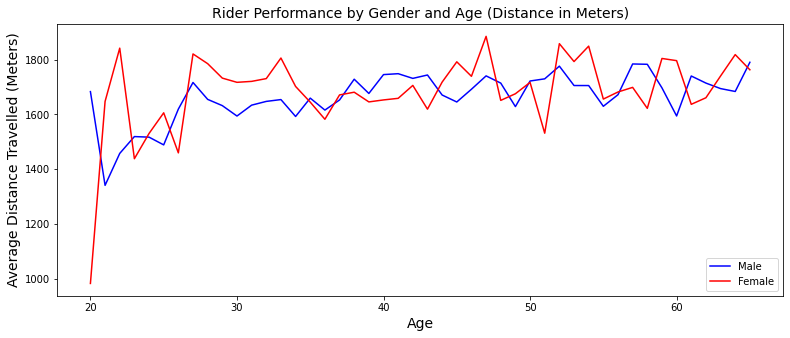

In [ ]:
#Rider Performance by Age & Gender as a measure of Distance (Meters)
fig3, ax3 = plt.subplots(figsize=(13,5))
df_dist_perf.groupby(['Age','Gender']).mean()['Distance Travelled (Meters)'].unstack().plot(ax=ax3, color = "br")
ax3.legend(['Male','Female'])
plt.xlabel('Age', fontsize=14)
plt.ylabel('Average Distance Travelled (Meters)', fontsize=14)
plt.title('Rider Performance by Gender and Age (Distance in Meters)',
          fontsize=14)
plt.show()

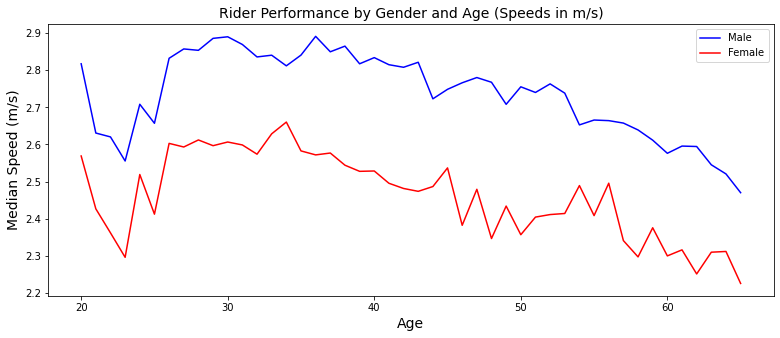

In [ ]:
#Rider Performance by Age & Gender as a measure of Median Speed (m/s)
fig4, ax4 = plt.subplots(figsize=(13,5))
df_speed_perf.groupby(['Age','Gender']).mean()['Median Speed (m/s)'].unstack().plot(ax=ax4, color = "br")
ax4.legend(['Male','Female'])
plt.xlabel('Age', fontsize=14)
plt.ylabel('Median Speed (m/s)', fontsize=14)
plt.title('Rider Performance by Gender and Age (Speeds in m/s)',
          fontsize=14)
plt.show()

##**Q5) Busiest Bike in NYC in 2017**

*How many times was it used? How many minutes was it used for?*

In [ ]:
#Numeric Bike ID values need to be converted to String data type
df['Bike ID'] = df['Bike ID'].astype(str)

#Number of times the busiest bike was used
df_bike_use = pd.DataFrame()
df_bike_use = df.groupby(['Bike ID']).size().reset_index(name = 'Number of Times Used')
df_bike_use = df_bike_use.sort_values('Number of Times Used', ascending = False)
df_bike_use = df_bike_use[:10]
df_bike_use['Bike ID'] = df_bike_use['Bike ID'].astype(str)
df_bike_use['Bike ID'] = ('Bike ID ' + df_bike_use['Bike ID'])

df_bike_use.head(10)

,Bike ID,Number of Times Used
7141,Bike ID 26386.0,176
6385,Bike ID 25408.0,174
7777,Bike ID 27060.0,171
7984,Bike ID 27277.0,169
7319,Bike ID 26573.0,168
7897,Bike ID 27185.0,165
6801,Bike ID 25857.0,165
6518,Bike ID 25556.0,160
7995,Bike ID 27288.0,159
6280,Bike ID 25293.0,159


####**Visualizing Busiest Bikes By Usage**

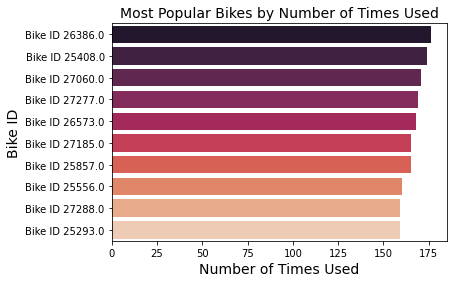

In [ ]:
#Visualizing
ax4 = sns.barplot('Number of Times Used', 'Bike ID',data = df_bike_use, palette="rocket")
ax4.set_title('Most Popular Bikes by Number of Times Used', fontsize=14)
ax4.set_xlabel("Number of Times Used", fontsize=14)
ax4.set_ylabel("Bike ID", fontsize=14)
#for index, row in df_bike_use.iterrows():
    #ax4.text(row['Number of Times Used']-80,
             #index,(str(row['Number of Times Used'])+" times"), 
             #color='white', ha="center", fontsize =10)
plt.show()

In [ ]:
#Finding the most frequently occurring Bike ID in the dataset
busiest_bike = df_bike_use['Bike ID'].loc[df_bike_use['Number of Times Used'] == df_bike_use['Number of Times Used'].max()].to_frame()
print("The busiest bike is: \n", busiest_bike, '\n')

#Number of times the busiest bike was used
df.groupby(['Bike ID']).size().reset_index(name = 'Number of Times Used')
print("Number of times the busiest bike was used:", 
      df_bike_use['Number of Times Used'].max(), "times")

#Duration of travel by the most frequently use bike
bike_min_df = pd.DataFrame()
bike_min_df['Minutes Used'] = (df.groupby('Bike ID')['Trip Duration'].sum())/60
bike_min_df = bike_min_df.reset_index()
bike_min_df = bike_min_df.sort_values('Minutes Used', ascending = False)
bike_min_df['Bike ID'] = bike_min_df['Bike ID'].astype(str)
bike_min_df['Bike ID'] = ('Bike ' + bike_min_df['Bike ID'])
bike_min_df = bike_min_df[:10]
print("\n")
print("Time travelled by the Bike in Minutes:")
bike_min_df.head()

The busiest bike is: 
               Bike ID
7141  Bike ID 26386.0 

Number of times the busiest bike was used: 176 times


Time travelled by the Bike in Minutes:


,Bike ID,Minutes Used
7141,Bike 26386.0,1989.300000
6952,Bike 26022.0,1914.200000
6280,Bike 25293.0,1896.050000
6385,Bike 25408.0,1845.266667
6801,Bike 25857.0,1837.750000


####**Visualizing Busiest Bikes By Minutes**

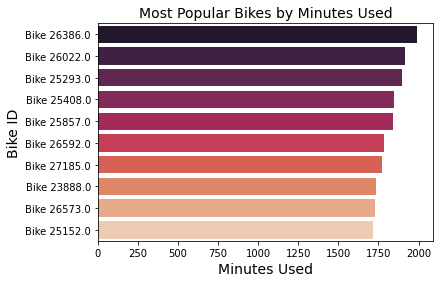

In [ ]:
#Visualizing
ax5 = sns.barplot('Minutes Used', 'Bike ID',data = bike_min_df, palette="rocket")
ax5.set_title('Most Popular Bikes by Minutes Used', fontsize=14)
ax5.set_xlabel('Minutes Used', fontsize=14)
ax5.set_ylabel('Bike ID', fontsize=14)
#for index, row in bike_min_df.iterrows():
    #ax5.text(row['Minutes Used']-110,
             #index,(str(round(row['Minutes Used'],2))+" times"), 
             #color='white', ha="center", fontsize=14)
plt.show()

*Busiest Bike ID:* **26386**

*No. of times used:* **254**

*Time in Minutes:* **2805.8**

##**Pre-processed Data for Modelling**

In [ ]:
df.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender,Count,Distance Travelled (Meters),Median Speed (m/s),Age
0,680,2017-01-01 00:00:21,2017-01-01 00:11:41,3226.0,W 82 St & Central Park West,40.782750,-73.971370,3165.0,Central Park West & W 72 St,40.775794,-73.976206,25542.0,Subscriber,1965.0,2.0,3,874.394902,1.285875,55.0
1,1282,2017-01-01 00:00:45,2017-01-01 00:22:08,3263.0,Cooper Square & E 7 St,40.729236,-73.990868,498.0,Broadway & W 32 St,40.748549,-73.988084,21136.0,Subscriber,1987.0,2.0,2,2160.858819,1.685537,33.0
6,559,2017-01-01 00:05:00,2017-01-01 00:14:20,499.0,Broadway & W 60 St,40.769155,-73.981918,479.0,9 Ave & W 45 St,40.760193,-73.991255,27294.0,Subscriber,1973.0,1.0,26,1269.844833,2.271637,47.0
7,826,2017-01-01 00:05:37,2017-01-01 00:19:24,362.0,Broadway & W 37 St,40.751726,-73.987535,445.0,E 10 St & Avenue A,40.727408,-73.981420,23288.0,Subscriber,1977.0,2.0,2,2753.588103,3.333642,43.0
8,255,2017-01-01 00:05:47,2017-01-01 00:10:02,430.0,York St & Jay St,40.701485,-73.986569,242.0,Carlton Ave & Flushing Ave,40.697787,-73.973736,25041.0,Subscriber,1989.0,1.0,81,1157.737648,4.540148,31.0


In [ ]:
df.shape

(412211, 19)

In [ ]:
df.columns

Index(['Trip Duration', 'Start Time', 'Stop Time', 'Start Station ID',
       'Start Station Name', 'Start Station Latitude',
       'Start Station Longitude', 'End Station ID', 'End Station Name',
       'End Station Latitude', 'End Station Longitude', 'Bike ID', 'User Type',
       'Birth Year', 'Gender', 'Count', 'Distance Travelled (Meters)',
       'Median Speed (m/s)', 'Age'],
      dtype='object')

In [ ]:
df.to_csv('Preprocessed_CitiBike_2017.csv')  

##**Predictive Modelling**

#####**EDA for Modelling**

#####**Baseline Model - I (Dummy Predictor)**